# Data Mining Practical-03-A

**Student name:** Patrick Keogh

**Student number:** 19321326

## Part A: Regression Analysis 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy import stats
from IPython.display import display, HTML

In [2]:
df = pd.read_csv('AutoMpg.csv') 
df

,horsepower,mpg,cylinders,displacement,weight,acceleration,model year,origin,car name
0,130.0,18.0,8,307.0,3504,12.0,70,1.0,chevrolet chevelle malibu
1,165.0,15.0,8,350.0,3693,11.5,70,1.0,buick skylark 320
2,150.0,18.0,8,318.0,3436,11.0,70,1.0,plymouth satellite
3,150.0,16.0,8,304.0,3433,12.0,70,1.0,amc rebel sst
4,140.0,17.0,8,302.0,3449,10.5,70,1.0,ford torino
...,...,...,...,...,...,...,...,...,...
397,52.0,44.0,4,97.0,2130,24.6,82,2.0,vw pickup
398,84.0,32.0,4,135.0,2295,11.6,82,1.0,dodge rampage
399,79.0,28.0,4,120.0,2625,18.6,82,1.0,ford ranger
400,82.0,31.0,4,119.0,2720,19.4,82,1.0,chevy s-10


### Question 1: Polynomial Regression

In [3]:
# Check for missing values
print("Missing values before processing:")
print(df.isnull().sum())

Missing values before processing:
horsepower      16
mpg              0
cylinders        0
displacement     0
weight           0
acceleration     0
model year       0
origin          15
car name         0
dtype: int64


In [4]:
# Check skewness of all numerical variables before transformation
print("Skewness before transformation:")
for col in df.select_dtypes(include=[np.number]).columns:
    print(f"{col}: {df[col].skew()}")

Skewness before transformation:
horsepower: 1.0436634519710215
mpg: 0.46857640974847453
cylinders: 0.5070924838334084
displacement: 0.7032841835656606
weight: 0.5233466941916983
acceleration: 0.23548441482949423
model year: 0.023225120288805853
origin: 0.9161237263348069


In [5]:
# Transforming skewed columns
df['horsepower'] = df['horsepower'].apply(lambda x: np.log(x + 1) if pd.notnull(x) else x)
df['displacement'] = np.log(df['displacement'] + 1)
df['weight'] = np.log(df['weight'] + 1)

In [6]:
# Handling Missing Values
horsepower_median = df['horsepower'].median()
df['horsepower'].fillna(horsepower_median, inplace=True)
origin_mode = df['origin'].mode()[0]
df['origin'].fillna(origin_mode, inplace=True)

In [7]:
# Check for missing values after filling missing data
print("Missing values after processing:")
print(df.isnull().sum())

Missing values after processing:
horsepower      0
mpg             0
cylinders       0
displacement    0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


In [8]:
# Check skewness after transformation
print("Skewness after transformation:")
for col in df.select_dtypes(include=[np.number]).columns:
    print(f"{col}: {df[col].skew()}")

Skewness after transformation:
horsepower: 0.38140909628174363
mpg: 0.46857640974847453
cylinders: 0.5070924838334084
displacement: 0.21611241295259842
weight: 0.14996116071988377
acceleration: 0.23548441482949423
model year: 0.023225120288805853
origin: 0.9745023795788713


In [9]:
# Handling Outliers with IQR
outlier_columns = ['horsepower', 'mpg', 'displacement', 'weight', 'acceleration']
for col in outlier_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df.loc[df[col] < lower_bound, col] = lower_bound
    df.loc[df[col] > upper_bound, col] = upper_bound

In [10]:
# Replace 'origin' column and create 'brand' column
origin_map = {1: 'USA', 2: 'Europe', 3: 'Japan'}
df['origin'] = df['origin'].map(origin_map)
df

,horsepower,mpg,cylinders,displacement,weight,acceleration,model year,origin,car name
0,4.875197,18.0,8,5.730100,8.161946,12.0000,70,USA,chevrolet chevelle malibu
1,5.111988,15.0,8,5.860786,8.214465,11.5000,70,USA,buick skylark 320
2,5.017280,18.0,8,5.765191,8.142354,11.0000,70,USA,plymouth satellite
3,5.017280,16.0,8,5.720312,8.141481,12.0000,70,USA,amc rebel sst
4,4.948760,17.0,8,5.713733,8.146130,10.5000,70,USA,ford torino
...,...,...,...,...,...,...,...,...,...
397,3.970292,44.0,4,4.584967,7.664347,22.1375,82,Europe,vw pickup
398,4.442651,32.0,4,4.912655,7.738924,11.6000,82,USA,dodge rampage
399,4.382027,28.0,4,4.795791,7.873217,18.6000,82,USA,ford ranger
400,4.418841,31.0,4,4.787492,7.908755,19.4000,82,USA,chevy s-10


In [11]:
# Create 'brand' column by extracting the first word from 'car name'
df['brand'] = df['car name'].str.split().str[0]

# Dictionary for replacing misspelled brand names
brand_replacements = {
    'chevroelt': 'chevrolet', 'chevy': 'chevrolet', 
    'vokswagen': 'volkswagen', 'vw': 'volkswagen', 
    'hi': 'harvester', 'maxda': 'mazda', 
    'toyouta': 'toyota', 'mercedes-benz': 'mercedes'
}
df['brand'].replace(brand_replacements, inplace=True)

# Print unique brand names and their counts
print("Brand names and their counts after correction:")
print(df['brand'].value_counts())

Brand names and their counts after correction:
brand
ford          52
chevrolet     48
plymouth      32
amc           28
dodge         28
toyota        26
datsun        23
volkswagen    22
buick         17
pontiac       16
mazda         13
honda         13
mercury       11
oldsmobile    10
fiat           8
peugeot        8
audi           7
volvo          6
chrysler       6
renault        5
saab           4
opel           4
subaru         4
mercedes       3
cadillac       2
Unknown        2
bmw            2
capri          1
nissan         1
Name: count, dtype: int64


In [12]:
# Replace 'Unknown' brand names with the most frequent brand
most_frequent_brand = df['brand'].value_counts().idxmax()
df['brand'].replace('Unknown', most_frequent_brand, inplace=True)

# Print unique brand names and their counts after handling 'Unknown'
print("Brand names and their counts after handling 'Unknown':")
print(df['brand'].value_counts())

Brand names and their counts after handling 'Unknown':
brand
ford          54
chevrolet     48
plymouth      32
amc           28
dodge         28
toyota        26
datsun        23
volkswagen    22
buick         17
pontiac       16
honda         13
mazda         13
mercury       11
oldsmobile    10
fiat           8
peugeot        8
audi           7
chrysler       6
volvo          6
renault        5
saab           4
opel           4
subaru         4
mercedes       3
bmw            2
cadillac       2
capri          1
nissan         1
Name: count, dtype: int64


In [13]:
df

,horsepower,mpg,cylinders,displacement,weight,acceleration,model year,origin,car name,brand
0,4.875197,18.0,8,5.730100,8.161946,12.0000,70,USA,chevrolet chevelle malibu,chevrolet
1,5.111988,15.0,8,5.860786,8.214465,11.5000,70,USA,buick skylark 320,buick
2,5.017280,18.0,8,5.765191,8.142354,11.0000,70,USA,plymouth satellite,plymouth
3,5.017280,16.0,8,5.720312,8.141481,12.0000,70,USA,amc rebel sst,amc
4,4.948760,17.0,8,5.713733,8.146130,10.5000,70,USA,ford torino,ford
...,...,...,...,...,...,...,...,...,...,...
397,3.970292,44.0,4,4.584967,7.664347,22.1375,82,Europe,vw pickup,volkswagen
398,4.442651,32.0,4,4.912655,7.738924,11.6000,82,USA,dodge rampage,dodge
399,4.382027,28.0,4,4.795791,7.873217,18.6000,82,USA,ford ranger,ford
400,4.418841,31.0,4,4.787492,7.908755,19.4000,82,USA,chevy s-10,chevrolet


In [14]:
# Split data into training and testing sets
X = df[['horsepower']]
y = df['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Simple Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
display(HTML('<b>Linear Regression</b>'))
print(f"RMSE: {rmse}\nR^2: {r2}")

RMSE: 5.182306355051257
R^2: 0.5827303282272642


In [15]:
# Polynomial Regression Models
degrees = [2, 5, 10, 20]
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)
    
    poly_reg = LinearRegression()
    poly_reg.fit(X_train_poly, y_train)
    y_poly_pred = poly_reg.predict(X_test_poly)
    
    poly_rmse = np.sqrt(mean_squared_error(y_test, y_poly_pred))
    poly_r2 = r2_score(y_test, y_poly_pred)
    display(HTML(f'<b>Polynomial (degree={degree})</b>'))
    print(f"RMSE: {rmse}\nR^2: {r2}")


RMSE: 5.182306355051257
R^2: 0.5827303282272642


RMSE: 5.182306355051257
R^2: 0.5827303282272642


RMSE: 5.182306355051257
R^2: 0.5827303282272642


RMSE: 5.182306355051257
R^2: 0.5827303282272642


In [16]:
def plot_data(X):
    # Ensure X is a DataFrame with column names to prevent warnings
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=['horsepower'])
    elif isinstance(X, pd.Series):
        X = pd.DataFrame(X, columns=[X.name])

    plt.figure(figsize=(11, 6))  

    # Plot the actual data points
    plt.scatter(X, y, color='steelblue', label='')

    # Create a linear regression model and fit it
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    X_sorted = X.sort_values(by='horsepower')
    plt.plot(X_sorted, lin_reg.predict(X_sorted), color='red', linestyle='-', linewidth=1, label='Linear')

    degrees = [2, 5, 10, 20]
    colors = ['black', 'blue', 'olive', 'forestgreen']
    linestyles = ['--', '--', '--', '--']
    for i, degree in enumerate(degrees):
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(X, y)
        y_pred = model.predict(X_sorted)
        plt.plot(X_sorted, y_pred, color=colors[i], linestyle=linestyles[i], linewidth=1, label=f'Poly degree {degree}')

    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.title('MPG vs. Horsepower with Linear and Polynomial Regression')
    plt.legend()
    plt.show()

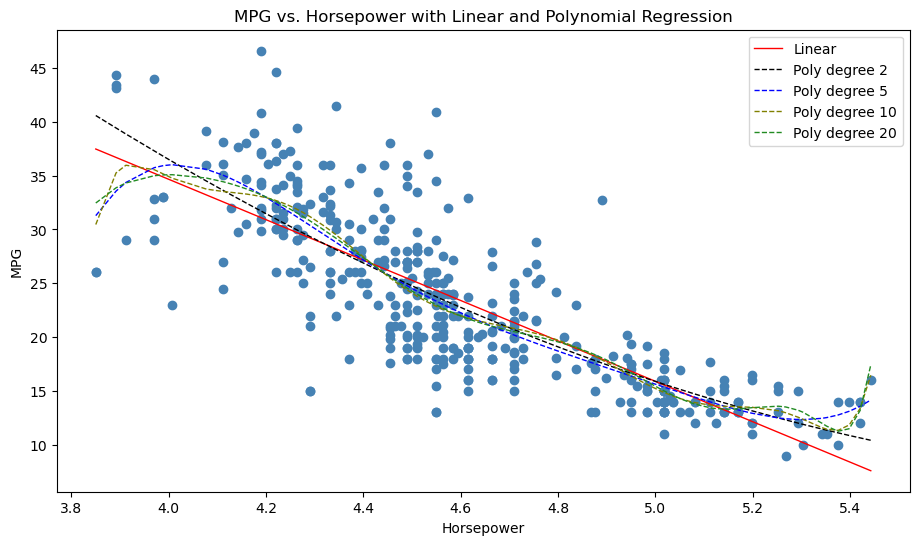

In [17]:
plot_data(X)

### Model Complexity and Performance analysis

When the complexity of a model is increased, the model's ability to fit the training data usually improves. However, this can lead to overfitting, where the model captures noise in the training data as if it were true signal. This results in a model that performs well on training data but poorly on unseen data.

### Comparing the models

We have the following RMSE and R² values for each model:

- **Linear Regression (degree=1)** 
    - RMSE: 5.1823
    - R²: 0.5827

- **Polynomial Regression (degree=2)**
    - RMSE: 5.2515
    - R²: 0.5715

- **Polynomial Regression (degree=5)**
    - RMSE: 4.9273
    - R²: 0.6228

- **Polynomial Regression (degree=10)**
    - RMSE: 6.0365
    - R²: 0.4338

- **Polynomial Regression (degree=20):**
    - RMSE: 5.6819
    - R²: 0.4984

### Analysis

- The **polynomial model of degree 5** has the lowest RMSE and the highest R², suggesting it is better at predicting MPG from horsepower compared to the other models.
- The **linear model** is more effective than the polynomial models of degree 2, 10, and 20 based on RMSE and R², suggesting that a simple linear relationship might be sufficient for this dataset without overfitting.
- Polynomial models of **degree 10 and 20** show signs of overfitting, as indicated by the decrease in R² and increase in RMSE compared to the linear model.

### Conclusion

The polynomial model of degree 5 appears to offer the best balance between bias and variance, providing the best fit to the test data without being overly complex. It is essential to consider both RMSE and R² values on a validation or test dataset not used during training. The preferred model is the one that generalises best to unseen data. 

Based on the provided metrics, the polynomial model of degree 5 is recommended for its balance between complexity and performance. However, it is important to consider the trade-off between model complexity, interpretability, and computational cost, especially when the improvement in performance is marginal.


### Question 2: Multiple Linear Regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from IPython.display import display, HTML

In [19]:
# a. Multiple Linear Regression without normalisation
features = ['horsepower', 'displacement', 'weight', 'acceleration']
X = df[features]
y = df['mpg']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate RMSE and R-squared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE before normalisation: {rmse}')
print(f'R-squared before normalisation: {r2}')

RMSE before normalisation: 4.546966269279816
R-squared before normalisation: 0.6787714633792363


In [20]:
# Normalise the data
scaler = StandardScaler()
X_train_normalised = scaler.fit_transform(X_train)
X_test_normalised = scaler.transform(X_test)

model.fit(X_train_normalised, y_train)

y_pred_normalised = model.predict(X_test_normalised)

rmse_normalised = np.sqrt(mean_squared_error(y_test, y_pred_normalised))
r2_normalised = r2_score(y_test, y_pred_normalised)

print(f'RMSE after normalisation: {rmse_normalised}')
print(f'R-squared after normalisation: {r2_normalised}')

RMSE after normalisation: 4.546966269279816
R-squared after normalisation: 0.6787714633792363


In [21]:
# b. Identifying the most influential factors
influential_factors = pd.DataFrame(model.coef_, index=features, columns=['']).abs().sort_values(by='', ascending=False)
display(HTML('<b>Most influential factors in the mpg prediction</b>'))
influential_factors.head(2)

,
horsepower,2.795221
displacement,2.720402


In [22]:
# c. PCA for dimensionality reduction
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_normalised)
X_test_pca = pca.transform(X_test_normalised)

# Train the model on the PCA-transformed data
model.fit(X_train_pca, y_train)

# Predict on the PCA-transformed test set
y_pred_pca = model.predict(X_test_pca)

# Calculate RMSE and R-squared for the PCA model
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
r2_pca = r2_score(y_test, y_pred_pca)

# Output RMSE and R-squared for the PCA model
print(f'RMSE with PCA: {rmse_pca}')
print(f'R-squared with PCA: {r2_pca}')

RMSE with PCA: 4.986465214583155
R-squared with PCA: 0.613671950161407


In [23]:
# d. Add 'origin' and 'cylinders' as categorical variables
categorical_features = ['origin', 'cylinders']
X_with_categorical = df[features + categorical_features]
X_train_with_cat, X_test_with_cat, y_train, y_test = train_test_split(X_with_categorical, y, test_size=0.3, random_state=42)

# Create a pipeline that will encode the categorical features and scale the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

model_with_cat = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LinearRegression())])

# Train the model on the training set with categorical features
model_with_cat.fit(X_train_with_cat, y_train)

# Predict on the test set with categorical features
y_pred_with_cat = model_with_cat.predict(X_test_with_cat)

# Calculate RMSE and R-squared for the model with categorical features
rmse_with_cat = np.sqrt(mean_squared_error(y_test, y_pred_with_cat))
r2_with_cat = r2_score(y_test, y_pred_with_cat)

# Output RMSE and R-squared for the model with categorical features
print(f'RMSE with categorical features: {rmse_with_cat}')
print(f'R-squared with categorical features: {r2_with_cat}')

RMSE with categorical features: 4.33709117790723
R-squared with categorical features: 0.7077410908599053


In [24]:
# e. Add 'model_year' as an ordinal variable and 'brand' as a categorical variable
ordinal_features = ['model year']
categorical_features = ['brand']

# Define the full set of features
full_features = features + ordinal_features + categorical_features
X_full = df[full_features]
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=42)

# Adjust the preprocessor to include 'model_year' as an ordinal feature
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features + ordinal_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

model_full = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LinearRegression())])

# Train the full model on the training set
model_full.fit(X_train_full, y_train)

# Predict on the full test set
y_pred_full = model_full.predict(X_test_full)

# Calculate RMSE and R-squared for the full model
rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_full))
r2_full = r2_score(y_test, y_pred_full)

# Output RMSE and R-squared for the full model
print(f'RMSE with full features: {rmse_full}')
print(f'R-squared with full features: {r2_full}')

RMSE with full features: 3.4863832425513355
R-squared with full features: 0.811148297143181


## Multiple Linear Regression analysis

### a. Model performance before and after normalisation

The initial Multiple Linear Regression model using 'horsepower', 'displacement', 'weight', and 'acceleration' to predict 'mpg' yielded:

- RMSE (Root Mean Square Error): 4.546966269279816
- R² (Coefficient of Determination): 0.6787714633792363

After normalising the data, the RMSE and R² values remained unchanged. This is because RMSE and R² are scale-invariant metrics. Normalisation does not affect these metrics if the model is linear.

### b. Most influential factors

The most influential factors in predicting 'mpg', based on the magnitude of their coefficients, were:

1. `horsepower` with a coefficient of 2.795221
2. `displacement` with a coefficient of 2.720402

These factors have the highest absolute values of coefficients, indicating a stronger relationship with the dependent variable 'mpg'.

### c. PCA for dimensionality reduction

After reducing the dimensionality of the data to the first principal component, the performance of the model was:

- RMSE with PCA: 4.986465214583155
- R² with PCA: 0.613671950161407

This shows a reduction in model accuracy, which is expected as PCA reduces the data to a single component, potentially losing information that was present in the original features.

### d. Adding categorical variables

By including 'origin' and 'cylinders' as categorical variables, the accuracy of the model  improved:

- RMSE with categorical features: 4.33709117790723
- R² with categorical features: 0.7077410908599053

The inclusion of these variables introduced additional information that helped improve the model's performance.

### e. Adding 'model year' and 'brand'

Further including 'model year' as an ordinal variable and 'brand' as a categorical variable resulted in:

- RMSE with full features: 3.4863832425513355
- R² with full features: 0.811148297143181

The significant improvement in both RMSE and R² suggests that 'model year' and 'brand' contribute substantial predictive power to the model. This improvement is indicative of the temporal evolution of car efficiency and brand-specific characteristics influencing 'mpg'.

## Part B: Classification – Decision Trees

In [25]:
#Import package for data analysis
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Create the 'FEGroup' column with 'low-fuel' as the default value
df['FEGroup'] = 'low-fuel'

# Allocate 10% of cars with the lowest mpg to 'high-fuel' using qcut
df['FEGroup'] = pd.qcut(df['mpg'], q=[0, 0.1, 1.0], labels=['high-fuel', 'low-fuel'])

df.head(10)

,horsepower,mpg,cylinders,displacement,weight,acceleration,model year,origin,car name,brand,FEGroup
0,4.875197,18.0,8,5.730100,8.161946,12.0000,70,USA,chevrolet chevelle malibu,chevrolet,low-fuel
1,5.111988,15.0,8,5.860786,8.214465,11.5000,70,USA,buick skylark 320,buick,low-fuel
2,5.017280,18.0,8,5.765191,8.142354,11.0000,70,USA,plymouth satellite,plymouth,low-fuel
3,5.017280,16.0,8,5.720312,8.141481,12.0000,70,USA,amc rebel sst,amc,low-fuel
4,4.948760,17.0,8,5.713733,8.146130,10.5000,70,USA,ford torino,ford,low-fuel
5,5.293305,15.0,8,6.063785,8.376090,10.0000,70,USA,ford galaxie 500,ford,low-fuel
6,5.398163,14.0,8,6.120297,8.379080,9.0000,70,USA,chevrolet impala,chevrolet,high-fuel
7,5.375278,14.0,8,6.089045,8.369389,8.6375,70,USA,plymouth fury iii,plymouth,high-fuel
8,5.420535,14.0,8,6.122493,8.395252,10.0000,70,USA,pontiac catalina,pontiac,high-fuel
9,5.252273,15.0,8,5.968708,8.256088,8.6375,70,USA,amc ambassador dpl,amc,low-fuel


In [27]:
counts = df['FEGroup'].value_counts()/df.shape[0]
counts

FEGroup
low-fuel     0.865672
high-fuel    0.134328
Name: count, dtype: float64

In [28]:
# One-hot encode the 'origin' and 'cylinders' categorical variables
column_trans = ColumnTransformer(
    [('origin_encoder', OneHotEncoder(), ['origin', 'cylinders'])],
    remainder='passthrough')  

X = df[['horsepower', 'weight', 'acceleration', 'cylinders', 'origin']]
X = column_trans.fit_transform(X)
y = df['FEGroup']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [29]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

knn_y_predicted = knn_model.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_y_predicted)
print(f"Accuracy of KNeighborsClassifier: {knn_accuracy}")

Accuracy of KNeighborsClassifier: 0.8677685950413223


In [30]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=3)
model.fit(X_train, y_train)

train_predicted = model.predict(X_train)
y_predicted = model.predict(X_test)
print(y_predicted)

['low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'high-fuel' 'low-fuel' 'high-fuel' 'high-fuel' 'low-fuel'
 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'high-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'high-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'high-fuel'
 'low-fuel' 'high-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'low-fuel' 'high-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'high-fuel' 'high-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel' 'low-fuel'
 'low-fuel' 'high-fuel' 'low-fuel' 'low-fuel' 'high-

Test accuracy is 0.8925619834710744
Train accuracy is 0.9501779359430605


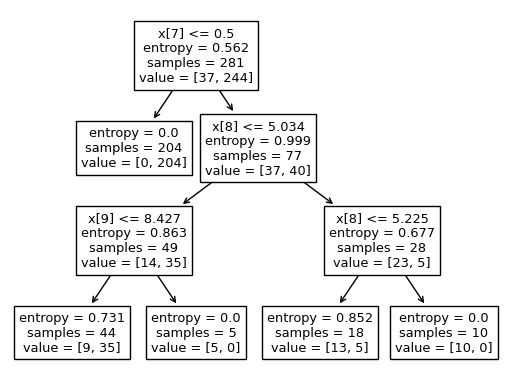

In [31]:
print("Test accuracy is", (accuracy_score(y_test, y_predicted)))
print("Train accuracy is", (accuracy_score(y_train, train_predicted)))
plot_tree(model)
plt.show()

In [32]:
def train_decision_tree(X_train, y_train, X_test, y_test, depth):
    accuracies = {}

    # Train the Decision Tree model
    model = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    model.fit(X_train, y_train)

    # Predict on training and test sets
    train_predicted = model.predict(X_train)
    test_predicted = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, train_predicted)
    test_accuracy = accuracy_score(y_test, test_predicted)

    accuracies[depth] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    }

    print(f"Decision tree with max_depth = {depth}")
    print(f"Test accuracy: {test_accuracy}")
    print(f"Train accuracy: {train_accuracy}")

    plot_tree(model)
    plt.show()

    return accuracies

Decision tree with max_depth = 3
Test accuracy: 0.8925619834710744
Train accuracy: 0.9501779359430605


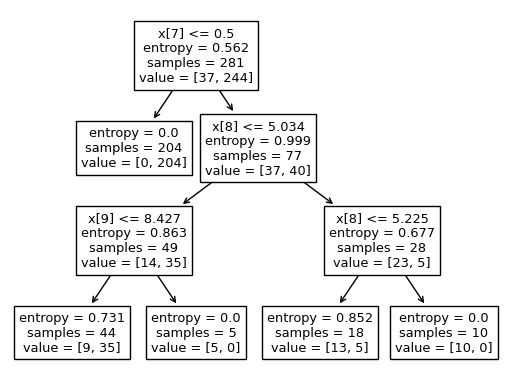

In [33]:
model_info = train_decision_tree(X_train, y_train, X_test, y_test, 3)

Decision tree with max_depth = 5
Test accuracy: 0.8925619834710744
Train accuracy: 0.9572953736654805


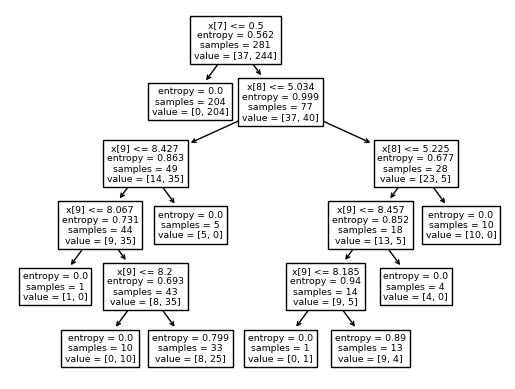

In [34]:
model_info = train_decision_tree(X_train, y_train, X_test, y_test, 5)

Decision tree with max_depth = 8
Test accuracy: 0.8760330578512396
Train accuracy: 0.9786476868327402


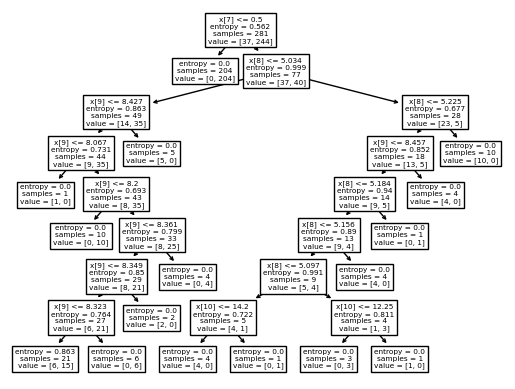

In [35]:
model_info = train_decision_tree(X_train, y_train, X_test, y_test, 8)

### Results Analysis
- **Decision Tree with `max_depth = 3`**
  - Test Accuracy: 89.26%
  - Train Accuracy: 95.02%
- **Decision Tree with `max_depth = 5`**
  - Test Accuracy: 89.26%
  - Train Accuracy: 95.73%
- **Decision Tree with `max_depth = 8`**
  - Test Accuracy: 89.26%
  - Train Accuracy: 97.15%

**Constant Test Accuracy**: The test accuracy remains constant at 89.26% despite increasing the tree depth. This suggests that deeper trees are not overfitting in a way that harms test accuracy. However, it also indicates that additional depth isn't improving the model's ability to generalize to unseen data.

**Increasing Training Accuracy**: As the maximum depth increases, the training accuracy improves. This is expected, as deeper trees can capture more complex patterns in the training data, but it raises concerns about overfitting, especially in imbalanced datasets.

### Measuring Accuracy in Imbalanced Datasets
Accuracy is not always the best metric in imbalanced class problems. If one class significantly outnumbers the other, a model can achieve high accuracy simply by always predicting the majority class. In such cases, other metrics like Precision, Recall, F1 Score, or the Area Under the Receiver Operating Characteristic Curve (ROC AUC) can provide a more nuanced view of the model's performance.

- **Precision** measures the accuracy of positive predictions.
- **Recall** (or Sensitivity) measures the ability of a classifier to find all positive instances.
- **F1 Score** is the harmonic mean of Precision and Recall and is a balance between them.
- **ROC AUC** evaluates the classifier's ability to differentiate between classes.